In [4]:
# -*- coding: utf-8 -*-
"""Transferlearning.ipynb
Automatically generated by Colaboratory.
## Transfer Learning (Tensorflow + VGG16 + CIFAR10)
The code below performs a complete task of transfer learning. All of it was made thinking of an easy way to learn this subject and an easy way to modify it in order to resolve other tasks.
###All the necessary imports
Note that this code was made for running on [Google Colab](https://colab.research.google.com/notebooks/welcome.ipynb). Then, its usage outside this plataform requires adaptations. As taking off all the Google Colab dependencies and download manually the VGG16 model and put it into the folder "./model". The model can be downloaded [here](https://github.com/ry/tensorflow-vgg16/blob/master/vgg16-20160129.tfmodel.torrent):
"""

# %matplotlib inline  
import pickle
import numpy as np
import os
from urllib.request import urlretrieve
import tarfile
import zipfile
import sys
import tensorflow as tf
import numpy as np
from time import time
import skimage as sk
from skimage import transform
from skimage import util
import random
import math
import os.path
from random import shuffle
import logging
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from itertools import product

logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [5]:
"""---
### Class that defines the principals hyperparameters used by the model
"""

class Hyperparameters:
  def __init__(self):
      self.image_size = 32
      self.image_channels = 3
      self.num_classes = 10
      self.initial_learning_rate = 1e-4
      self.decay_steps = 1e3
      self.decay_rate = 0.98
      self.cut_layer = "pool5"
      self.hidden_layers = [512]
      self.batch_size = 128
      self.num_epochs = 200
      self.check_points_path= "./tensorboard/cifar10_vgg16"
      self.keep = 1.0
      self.fine_tunning = False
      self.bottleneck = True

In [6]:

"""### Class that  provides same utilities for the model, such as downloads files,  gets dataset, does  data augmentation,  generates bottlenecks files and creates a confusion matrix from the model."""

class utils:
      def get_or_generate_bottleneck( sess, model, file_name, dataset, labels, batch_size = 128):

          path_file = os.path.join("./data_set",file_name+".pkl")
          if(os.path.exists(path_file)):
                print("Loading bottleneck from \"{}\" ".format(path_file))
                with open(path_file, 'rb') as f:
                   return pickle.load(f)

          bottleneck_data = []
          original_labels = []

          print("Generating Bottleneck \"{}.pkl\" ".format(file_name) )
          count = 0
          amount = len(labels) // batch_size
          indices = list(range(len(labels)))
          for i in range(amount+1):

                if (i+1)*batch_size < len(indices):
                  indices_next_batch = indices[i*batch_size: (i+1)*batch_size]
                else:
                   indices_next_batch = indices[i*batch_size:]
                batch_size = len(indices_next_batch)

                data = dataset[indices_next_batch]
                label = labels[indices_next_batch]
                input_size = np.prod(model["bottleneck_tensor"].shape.as_list()[1:])
                tensor = sess.run(model["bottleneck_tensor"], feed_dict={model["images"]:data, model["bottleneck_input"]:np.zeros((batch_size,input_size)), model["labels"]:label,model["keep"]:1.0})
                for t in range(batch_size):
                  bottleneck_data.append(np.squeeze(tensor[t]))
                  original_labels.append(np.squeeze(label[t]))
          
          bottleneck = {
              "data":np.array(bottleneck_data),
              "labels":np.array(original_labels)
          } 
          
          with open(path_file, 'wb') as f:
            pickle.dump(bottleneck, f)


          print("Done")   

          return bottleneck



      def get_data_set(name="train"):
          x = None
          y = None
          folder_name = 'cifar_10'
          main_directory = "./data_set"
          url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

          utils.maybe_download_and_extract(url, main_directory,folder_name, "cifar-10-batches-py")
          '''

          f = open(os.path.join(main_directory,folder_name,"batches.meta"), 'rb')
          f.close()

          if name is "train":
              for i in range(5):
                  f = open('./data_set/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
                  datadict = pickle.load(f, encoding='latin1')
                  f.close()

                  _X = datadict["data"]
                  _Y = datadict['labels']

                  _X = np.array(_X, dtype=float) / 255.0
                  _X = _X.reshape([-1, 3, 32, 32])
                  _X = _X.transpose([0, 2, 3, 1])

                  if x is None:
                      x = _X
                      y = _Y
                  else:
                      x = np.concatenate((x, _X), axis=0)
                      y = np.concatenate((y, _Y), axis=0)

          elif name is "test":
              f = open('./data_set/'+folder_name+'/test_batch', 'rb')
              datadict = pickle.load(f, encoding='latin1')
              f.close()

              x = datadict["data"]
              y = np.array(datadict['labels'])

              x = np.array(x, dtype=float) / 255.0
              x = x.reshape([-1, 3, 32, 32])
              x = x.transpose([0, 2, 3, 1])

          return x, utils._dense_to_one_hot(y)
          '''
          return None


      def _dense_to_one_hot( labels_dense, num_classes=10):
          num_labels = labels_dense.shape[0]
          index_offset = np.arange(num_labels) * num_classes
          labels_one_hot = np.zeros((num_labels, num_classes))
          labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1

          return labels_one_hot


      


      def maybe_download_and_extract( url, main_directory,filename, original_name):
          def _print_download_progress( count, block_size, total_size):
            pct_complete = float(count * block_size) / total_size
            msg = "\r --> progress: {0:.1%}".format(pct_complete)
            sys.stdout.write(msg)
            sys.stdout.flush()
          
          if not os.path.exists(main_directory):
              os.makedirs(main_directory)
              url_file_name = url.split('/')[-1]
              zip_file = os.path.join(main_directory,url_file_name)
              print("Downloading ",url_file_name)

              try:
                file_path, _ = urlretrieve(url=url, filename= zip_file, reporthook=_print_download_progress)
              except:
                os.system("rm -r "+main_directory)
                print("An error occurred while downloading: ",url)

                if(original_name == 'vgg16-20160129.tfmodel'):
                  print("This could be for a problem with github. We will try downloading from the Google Drive")
                  from google_drive_downloader import GoogleDriveDownloader as gdd

                  gdd.download_file_from_google_drive(file_id='1xJZDLu_TK_SyQz-SaetAL_VOFY7xdAt5',
                                                      dest_path='./models/vgg16-20160129.tfmodel',
                                                      unzip=False)
                else: print("This could be for a problem with the storage site. Try again later")
                return

              print("\nDownload finished.")
              if file_path.endswith(".zip"):
                  print( "Extracting files.")

                  zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
              elif file_path.endswith((".tar.gz", ".tgz")):
                  print( "Extracting files.")
                  tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
                  os.remove(file_path)

              os.rename(os.path.join(main_directory,original_name), os.path.join(main_directory,filename))
              print("Done.")
     
      def data_augmentation(images, labels):
        
          def random_rotation(image_array):
              # pick a random degree of rotation between 25% on the left and 25% on the right
              random_degree = random.uniform(-15, 15)
              return sk.transform.rotate(image_array, random_degree)

          def random_noise(image_array):
              # add random noise to the image
              return sk.util.random_noise(image_array)

          def horizontal_flip(image_array):
              # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
              return image_array[:, ::-1]
          print("Augmenting data...")
          aug_images = []
          aug_labels = []

          aug_images.extend( list(map(random_rotation, images)) )
          aug_labels.extend(labels)
          aug_images.extend( list(map(random_noise,    images)) )
          aug_labels.extend(labels)
          aug_images.extend( list(map(horizontal_flip, images)) )
          aug_labels.extend(labels)


          return np.array(aug_images), np.array(aug_labels)
        
        
        
      
      def generate_confusion_matrix( predictions, class_names):
        
        def plot_confusion_matrix(cm, classes,
                                    normalize=False,
                                    title='Confusion matrix',
                                    cmap=plt.cm.Blues):
                """
                This function prints and plots the confusion matrix.
                Normalization can be applied by setting `normalize=True`.
                """
                if normalize:
                    cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                    print("Normalized confusion matrix")
                else:
                    print('Confusion matrix, without normalization')

                print(cm.shape)

                plt.imshow(cm, interpolation='nearest', cmap=cmap)
                plt.title(title)
                plt.colorbar()
                
                tick_marks = np.arange(len(classes))
               
          
                plt.xticks(tick_marks, classes, rotation=45)
                plt.yticks(tick_marks, classes)

                fmt = '.2f' if normalize else 'd'
                thresh = cm.max() / 2.
                symbol = "%" if normalize else ""
                for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
                    plt.text(j, i, format(cm[i, j], fmt)+symbol,
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")

                plt.tight_layout()
                plt.ylabel('Real')
                plt.xlabel('Predicted')
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(predictions["labels"],predictions["classes"])
        np.set_printoptions(precision=2)
        

        # # Plot normalized confusion matrix
        plt.figure(figsize=(10,7))
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                            title='Normalized confusion matrix')
        plt.grid('off')

        #plt.savefig("./confusion_matrix.png") #Save the confision matrix as a .png figure.
        plt.show()

In [7]:
folder_name = 'input' # target name
main_directory = "./data_set"
url = "https://github.com/vfrocha/dl2018/raw/master/BCSinput.tar.gz"

utils.maybe_download_and_extract(url, main_directory, folder_name, "BCSinput")

 --> progress: 100.1%
Download finished.
Extracting files.
Done.


In [8]:
!ls data_set/input

BCS


# Identify Blood Cell Subtypes From Images
* Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
* Mononuclear (Basophil + Lymphocyte vs Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

An important problem in blood diagnostics is classifying different types of blood cells.  Here we have 410 original images and 12,500 augmented images of blood cells paired with subtype labels (Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil).  We want to automatically classify each image according to the subtype of cells within it.

For more information about blood cells and blood cell subtypes, see the following links:
https://www.ncbi.nlm.nih.gov/books/NBK2263/ and https://www.ncbi.nlm.nih.gov/books/NBK2263/box/A26/?report=objectonly

*Step One: Import Modules*

In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

*Step Two: Plot Data*

In [12]:
dict_characters = {0:'normal',1:'friction',2:'misalignment',3:'other',4:'sensor',5:'unbalance'}

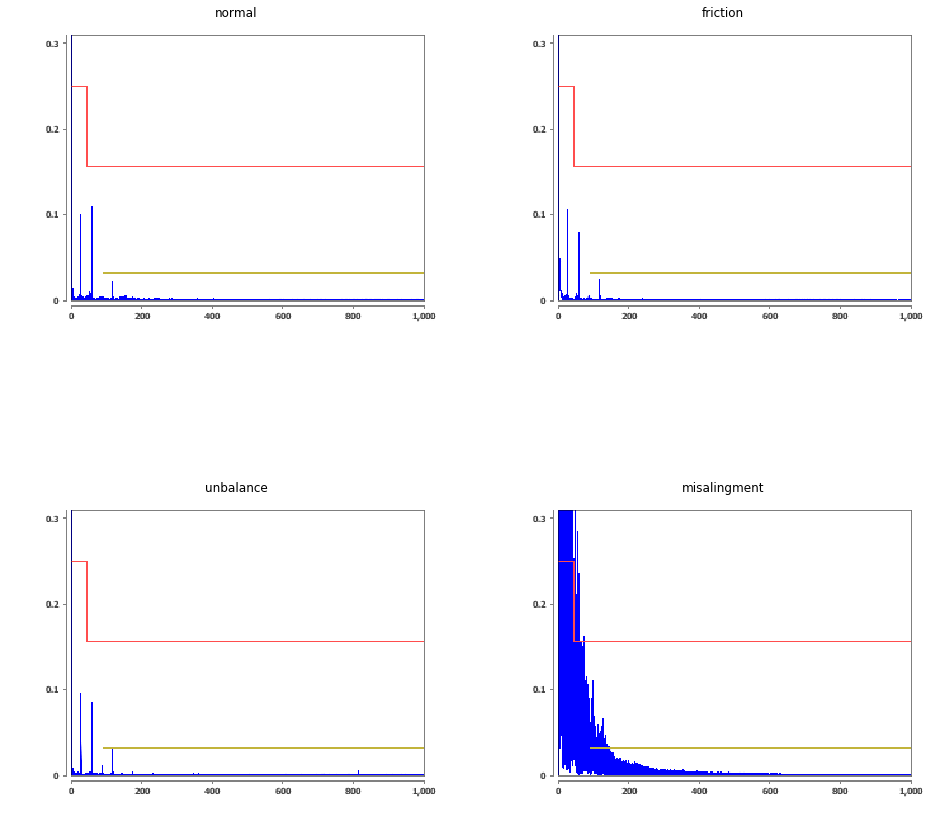

In [13]:
# Plot Image
def plotImage(image_location):
    image = plt.imread(image_name)
    plt.imshow(image)
    return
image_name = './data_set/input/BCS/images/TRAIN/normal/1Bomba_3_0.5_X_-_60_Teste1_0.png'
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.title('normal')
plt.axis('off') 
plotImage(image_name)
image_name = './data_set/input/BCS/images/TRAIN/friction/1Motor_1_0.0_X_-_60_Teste1_Roçamento_9.png'
plt.subplot(222)
plt.title('friction')
plt.axis('off') 
plotImage(image_name)
image_name = './data_set/input/BCS/images/TRAIN/misalignment/6Bomba_2_0.0_X_-_60_Teste6_Desalinhamento_10.png'
plt.subplot(223)
plt.title('unbalance')
plt.axis('off') 
plotImage(image_name)
plt.subplot(224)
image_name = './data_set/input/BCS/images/TRAIN/sensor/1Bomba_1_0.5_X_-_60_Teste1_Falha_de_Acelerômetro_em_X_7.png'
plt.title('misalingment')
plt.axis('off') 
plotImage(image_name)

*Step Three: Describe Data*

Here you can see that with the original images we have imbalanced class sizes.  We will use the augmented images instead because they no longer have imbalanced class sizes due to oversampling.

*Step Four: Load Augmented Dataset*

In [14]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    dict_characters = {0:'normal',1:'friction',2:'misalignment',3:'other',4:'sensor',5:'unbalance'}
    """
    X = []
    y = []
    z = []
    
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['normal']:
                label = 0
                label2 = 0
            elif wbc_type in ['friction']:
                label = 1
                label2 = 1
            elif wbc_type in ['misalignment']:
                label = 2  
                label2 = 1
            elif wbc_type in ['other']:
                label = 3 
                label2 = 1
            elif wbc_type in ['sensor']:
                label = 4 
                label2 = 1
            elif wbc_type in ['unbalance']:
                label = 5 
                label2 = 1
            else:
                print('labeling error')
                print('wbc_type=',wbc_type)
            cont0 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = plt.imread(folder + wbc_type + '/' + image_filename)[:,:,:3]
                if img_file is not None:
                    if label == 0:
                      cont0 += 1
                    if cont0 > 722:
                      continue
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 260, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('./data_set/input/BCS/images/TRAIN/')
X_test, y_test, z_test = get_data('./data_set/input/BCS/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 6)
y_testHot = to_categorical(y_test, num_classes = 6)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

  0%|          | 0/156 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 621/621 [00:02<00:00, 215.50it/s]


In [15]:
np.sum(y_train == 3)

334

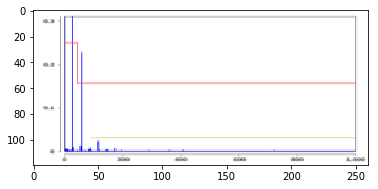

In [16]:
plt.imshow(X_train[0])
plt.show()

*Step Six: Preprocess Data*

In [15]:
np.sum(y_test == 3)

84

In [16]:
'''
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0
'''

'\nX_train=np.array(X_train)\nX_train=X_train/255.0\n\nX_test=np.array(X_test)\nX_test=X_test/255.0\n'

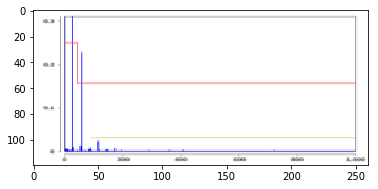

(120, 260, 3)


In [17]:
plt.imshow(X_train[0])
plt.show()
print(X_train[0].shape)

*Step Seven: Define Helper Functions*

In [18]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step Eight: Evaluate Classification Models*

In [ ]:
import keras
dict_characters = {0:'normal',1:'friction',2:'misalignment',3:'other',4:'sensor',5:'unbalance'}
dict_characters2 = {0:'normal',1:'fault'}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 5#30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=120,260
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = dict_characters
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_train,y_trainHot,X_test,y_testHot,1)

Epoch 1/5
45/45 [============================>.] - ETA: 0s - loss: 14.0540 - acc: 0.1278

90% accuracy is much better than random chance!  Now let's see if maybe this model will work better for a binary classification task such as determining whether the cell is polynuclear (e.g. neutrophil and eusinophil) or mononuclear (e.g. every other subtype).  

Epoch 1/5
46/45 [==============================] - 85s 2s/step - loss: 7.9004 - acc: 0.5094 - val_loss: 12.4494 - val_acc: 0.2276
Epoch 2/5
46/45 [==============================] - 85s 2s/step - loss: 7.9840 - acc: 0.5047 - val_loss: 12.4494 - val_acc: 0.2276
Epoch 3/5
46/45 [==============================] - 87s 2s/step - loss: 7.9840 - acc: 0.5047 - val_loss: 12.4494 - val_acc: 0.2276
Epoch 4/5
46/45 [==============================] - 85s 2s/step - loss: 8.1341 - acc: 0.4953 - val_loss: 12.4494 - val_acc: 0.2276
Epoch 5/5
46/45 [==============================] - 86s 2s/step - loss: 7.9090 - acc: 0.5093 - val_loss: 12.4494 - val_acc: 0.2276

Keras CNN #1C - accuracy: 0.22761194029850745 


             precision    recall  f1-score   support

     normal       0.00      0.00      0.00       621
      fault       0.23      1.00      0.37       183

avg / total       0.05      0.23      0.08       804



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


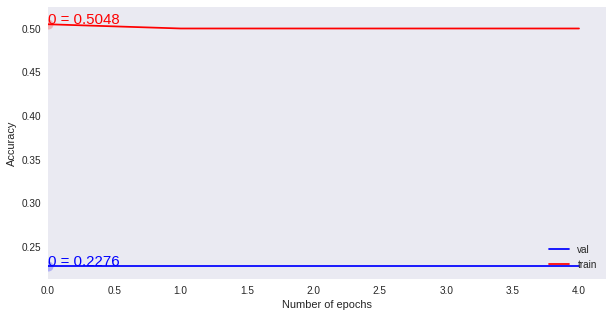

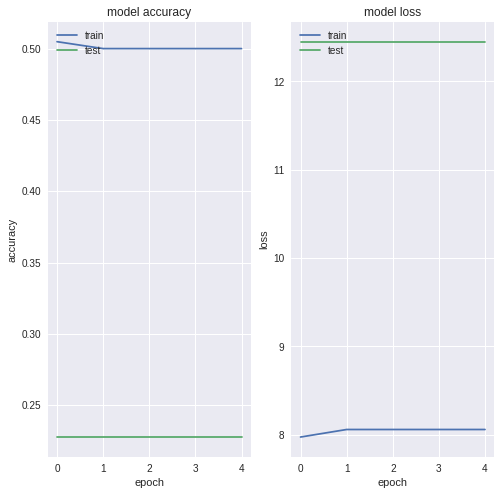

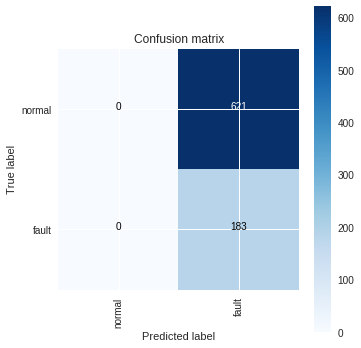

In [25]:
dict_characters = dict_characters2
runKerasCNNAugment(X_train,z_trainHot,X_test,z_testHot,2)